In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [37]:
data_scoring=pd.read_csv('credit_card_default_analysis.csv')

In [38]:
data_scoring.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


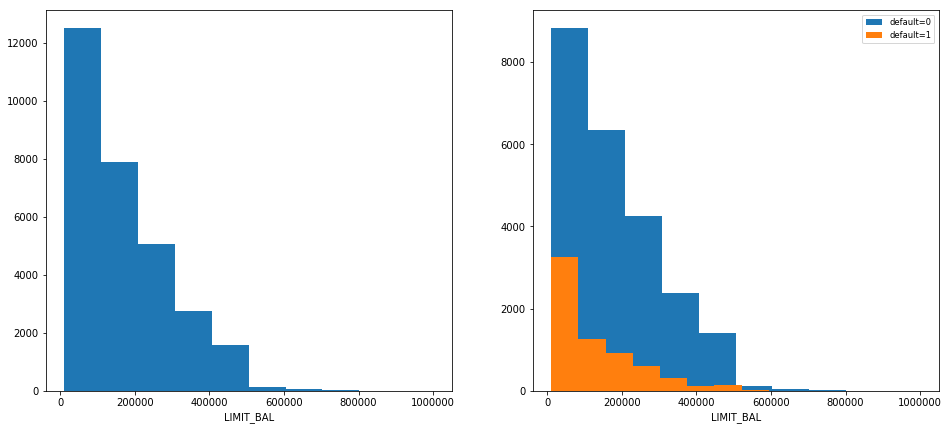

In [39]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(data_scoring.LIMIT_BAL)
plt.xlabel("LIMIT_BAL")
plt.subplot(122)
plt.hist(data_scoring[data_scoring.default==0].LIMIT_BAL,label='default=0')
plt.hist(data_scoring[data_scoring.default==1].LIMIT_BAL,label='default=1')
plt.xlabel("LIMIT_BAL")
plt.legend(loc=0,fontsize='small')

Из графика видно что люди чаще не возвращают небольшие суммы,при увеличении суммы количество невозвратов уменьшается. Распределение признака не похоже на нормальное.

Проверим гипотезу о равенстве медианных значений кредитного лимита c помощью подходящей интервальной оценки:
H0:медианные значения равны
Н1:медианные значения отличаются

In [40]:
limit_bal_default_0=data_scoring[data_scoring.default==0].LIMIT_BAL
limit_bal_default_1=data_scoring[data_scoring.default==1].LIMIT_BAL
print "Медиана LIMIT_BAL при default=0 %f"% limit_bal_default_0.median()
print "Медиана LIMIT_BAL при default=1 %f"% limit_bal_default_1.median()

Медиана LIMIT_BAL при default=0 150000.000000
Медиана LIMIT_BAL при default=1 90000.000000


ПРоверку будем проводить с помощью доверительного интервала построенного на основе бутстрепа

In [41]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [42]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [43]:
np.random.seed(0)
limit_bal_default_0_median_scores=map(np.median,get_bootstrap_samples(np.array(limit_bal_default_0),1000))
limit_bal_default_1_median_scores=map(np.median,get_bootstrap_samples(np.array(limit_bal_default_1),1000))

In [44]:
print "Точечная оценка разности медиан ",limit_bal_default_0.median()-limit_bal_default_1.median()

Точечная оценка разности медиан  60000.0


In [45]:
delta_median_scores=map(lambda x:x[0]-x[1],zip(limit_bal_default_0_median_scores,limit_bal_default_1_median_scores))

In [46]:
print "95% доверительный интервал разности медиан ",stat_intervals(delta_median_scores,0.05)

95% доверительный интервал разности медиан  [ 60000.  70000.]


Так как 0 не входит в 95% доверительный интервал разности медиан не входит 0, можно сделать вывод что медианы данных выборок различаются.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних:
H0:Распределения обоих выборок совпадают
H1:Распределения выборок различаются на дельта

Для проверки гипотезы используем перестановочный критерий

In [47]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [48]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [49]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [50]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [51]:
print "p_value",permutation_test(limit_bal_default_0,limit_bal_default_1,max_permutations=1000)

p_value 0.001


Гипотеза о том что распределения выборок равны отвергается на уровне значимости 0.05 с p_value=0.001

Результат является практически значимым потому что разница между медианами LIMIT_BAL при default=0 и default=1 значимо большая.

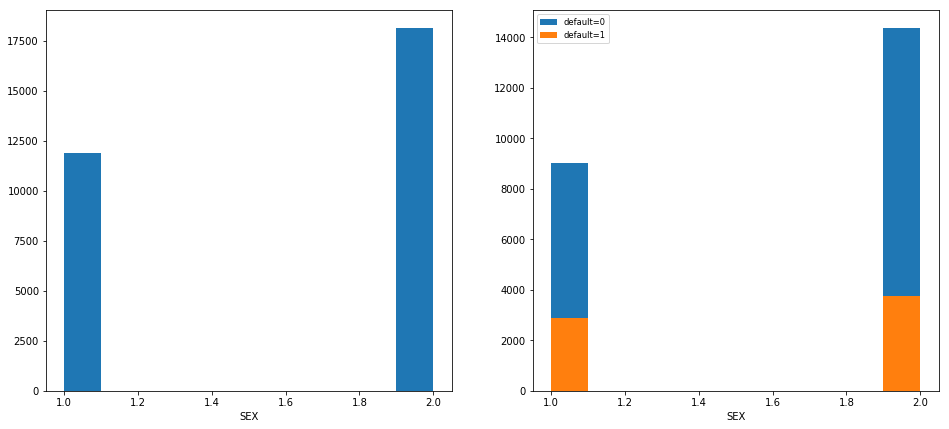

In [85]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(data_scoring.SEX)
plt.xlabel("SEX")
plt.subplot(122)
plt.hist(data_scoring[data_scoring.default==0].SEX,label='default=0')
plt.hist(data_scoring[data_scoring.default==1].SEX,label='default=1')
plt.xlabel("SEX")
plt.legend(loc=0,fontsize='small')

Из графика видно, что женщины не возвращают кредиты чаще чем мужчины.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

Построим доверительный интервал разности долей для выборок

In [66]:
sex_default_0=data_scoring[data_scoring.default==0].SEX.values
sex_default_1=data_scoring[data_scoring.default==1].SEX.values
sex_default_0=np.array([1 if x==2 else 0 for x in sex_default_0])
sex_default_1=np.array([1 if x==2 else 0 for x in sex_default_1])

In [69]:
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
print sex_default_0.mean()
print sex_default_1.mean()
print sex_default_0.mean()-sex_default_1.mean()

0.614149974319
0.567058468957
0.0470915053623


In [58]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [67]:
print "Доверительный интервал для разности долей",proportions_confint_diff_ind(sex_default_0,sex_default_1)

Доверительный интервал для разности долей (0.033634932749628671, 0.060548077974896725)


Доверительный интервал для разности долей не содержит 0, следовательно гендерный состав вернувших и не вернувших кредит различается.

Применим z-критерий для разности долей

In [70]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [71]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [72]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [74]:
print "p_value ",proportions_diff_z_test(proportions_diff_z_stat_ind(
sex_default_0,
sex_default_1))

 p_value  4.47286652161e-12


Гипотеза о том что гендерный состав людей вернувших и не вернувших кредит не отличаются отвергается с p-value=4.47286652161e-12

Данный результат имеет практическую значимость, так как среди не вернувших кредит женщин на 3-6% больше, что является значимым для банков.

In [136]:
educ_default=data_scoring.pivot_table("ID","EDUCATION",'default','count')

In [137]:
educ_default[np.isnan(educ_default)]=0
educ_default

default,0,1
EDUCATION,,
0,14.0,0.0
1,8549.0,2036.0
2,10700.0,3330.0
3,3680.0,1237.0
4,116.0,7.0
5,262.0,18.0
6,43.0,8.0


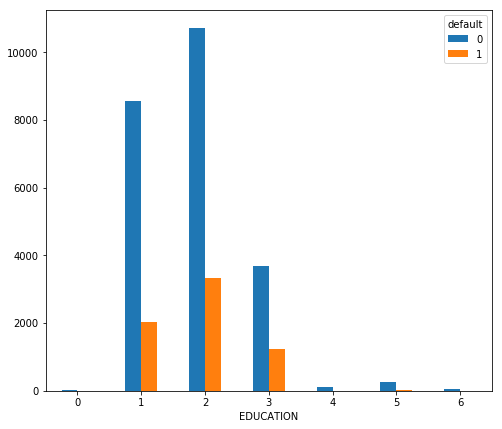

In [138]:
educ_default.plot.bar(rot=0,figsize=(8,7))

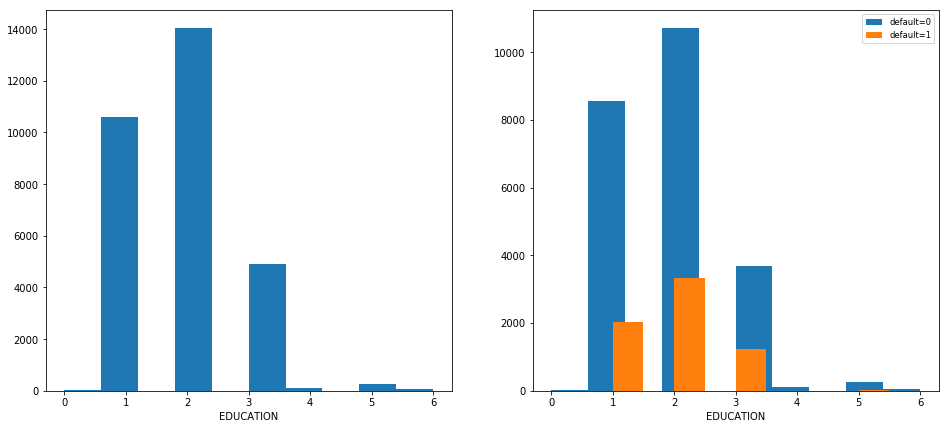

In [139]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(data_scoring.EDUCATION)
plt.xlabel("EDUCATION")
plt.subplot(122)
plt.hist(data_scoring[data_scoring.default==0].EDUCATION,label='default=0')
plt.hist(data_scoring[data_scoring.default==1].EDUCATION,label='default=1')
plt.xlabel("EDUCATION")
plt.legend(loc=0,fontsize='small')

Из графика видно,что чаще всего кредиты берут магистры и бакалавры.

Проверим гипотезу том, что образование не влияет на то, вернет ли человек долг. 

Для проверки гипотезы применим критерий xи-квадрат

Проверим что размер ввыборки > 40

In [140]:
print np.sum(np.array(educ_default))

30000.0


Проверим что элементов < 5 в таблице не более 20%

In [141]:
print 1.0*np.sum(np.array(educ_default)<5)/(educ_default.shape[0]*educ_default.shape[1])

0.0714285714286


Следовательно к данной выборке можно применить критерий хи-квадрат.

In [142]:
chi2, pval,dof, ex = stats.chi2_contingency(educ_default)
print "chi2 contingency: %.4f, p-value: %s" % (chi2, pval)

chi2 contingency: 163.2166, p-value: 1.23326262454e-32


Следовательно гипотеза о том, что образование не влияет на на то,вернет ли человек долг отвергается с p-value=1.23326262454e-32.

In [143]:
table_diff_ex_educ_default=pd.DataFrame(data=ex-educ_default,columns=educ_default.columns)

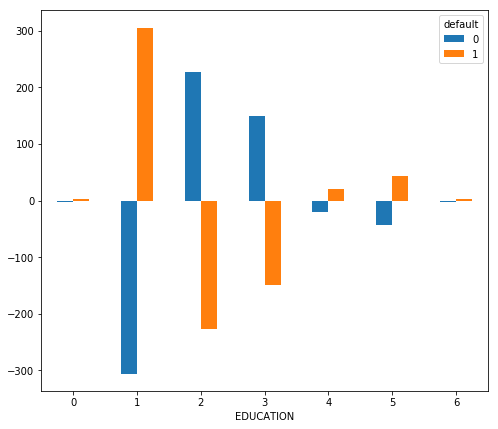

In [144]:
table_diff_ex_educ_default.plot.bar(rot=0,figsize=(8,7))

По графику видно,что значения разности в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг равны по модулю и противоположны по знаку.

In [145]:
table_diff_educ_default=pd.DataFrame(data=(educ_default.loc[:,0]-educ_default.loc[:,1]).reshape(1,7),
                                     columns=educ_default.index,index=['difference'])

C:\Users\dim\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


Выведем график разностей людей отдавших кредит и людей не выплативших кредит по всем категориям образования.

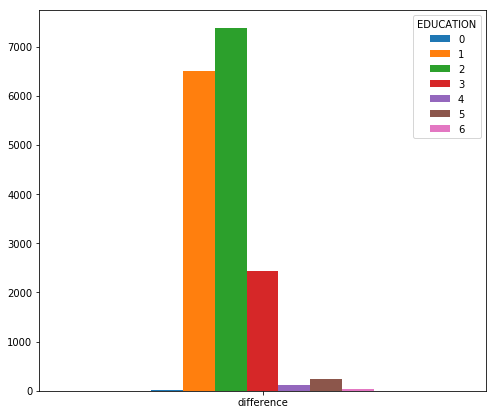

In [146]:
table_diff_educ_default.plot.bar(rot=0,figsize=(8,7))

Приведем значения ячеек к одному масштабу. Для этого разделим каждое значение разности на количество людей в этой подгруппе. Чем больше полученное значение, тем больше доля людей в этой группе, которые вернули кредит.

In [147]:
diff_scaled=(educ_default.loc[:,0]-educ_default.loc[:,1])/(educ_default.loc[:,0]+educ_default.loc[:,1])
table_diff_educ_default_scaled=pd.DataFrame(data=diff_scaled.reshape(1,7),
                                     columns=educ_default.index,index=['difference'])

C:\Users\dim\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


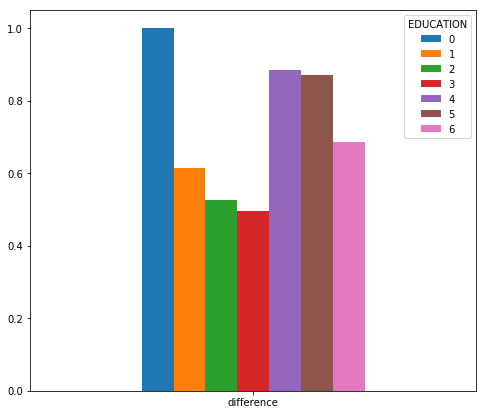

In [148]:
table_diff_educ_default_scaled.plot.bar(rot=0,figsize=(8,7))

Из гафика видно, что лучше всего кредиты отдают доктора наук,а хуже всего выпускники школы.

In [149]:
marriage_default=data_scoring.pivot_table("ID","MARRIAGE",'default','count')

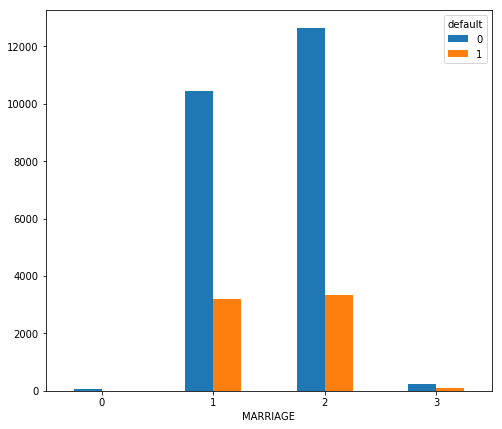

In [151]:
marriage_default.plot.bar(rot=0,figsize=(8,7))

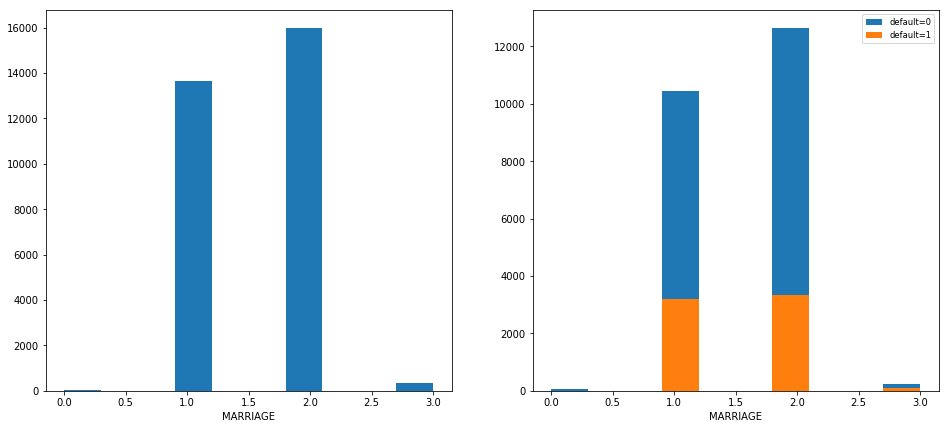

In [152]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(data_scoring.MARRIAGE)
plt.xlabel("MARRIAGE")
plt.subplot(122)
plt.hist(data_scoring[data_scoring.default==0].MARRIAGE,label='default=0')
plt.hist(data_scoring[data_scoring.default==1].MARRIAGE,label='default=1')
plt.xlabel("MARRIAGE")
plt.legend(loc=0,fontsize='small')

По графику видно,что холостые люди берут кредит чаще чем  женатые.Также видно, что количество людей не отадавших кредит не зависит от семейного статуса.

Проверим как связан семейный статус с индикатором дефолта

Так как оба признака категориальные для проверки корреляции нужно использовать коэффициент V-Крамера. ДЛя его вычисления используется хи-квадрат.

Проверим что размер ввыборки > 40

In [154]:
print np.sum(np.array(marriage_default))

30000


Проверим что элементов < 5 в таблице не более 20%

In [156]:
print 1.0*np.sum(np.array(marriage_default)<5)/(marriage_default.shape[0]*educ_default.shape[1])

0.0


Вычисляем хи-квадрат

In [157]:
chi2, pval,dof, ex = stats.chi2_contingency(marriage_default)

Вычисляем коэффициент корреляции V-Крамера

In [160]:
n=marriage_default.sum(axis=0).sum()
V_Cramer=(chi2/n)**0.5
print "Коэффициент корреляции V-Крамера",V_Cramer
print "Уровень значимости хи-квадрат",pval

Коэффициент корреляции V-Крамера 0.0344782036628
Уровень значимости хи-квадрат 8.82586245758e-08


Так как коэффициент корреляции V-Крамера очень мал можно предположить отсутствие связи между семейным статусом и индикатором дефолта.

Гипотеза о том, что семейный статус как-то связан с индикатором дефолта отвергается с p-value=8.82586245758e-08

In [163]:
age_default_0=data_scoring[data_scoring.default==0].AGE
age_default_1=data_scoring[data_scoring.default==1].AGE
print "Медиана AGE при default=0 %f"% age_default_0.median()
print "Медиана AGE при default=1 %f"% age_default_1.median()

Медиана AGE при default=0 34.000000
Медиана AGE при default=1 34.000000


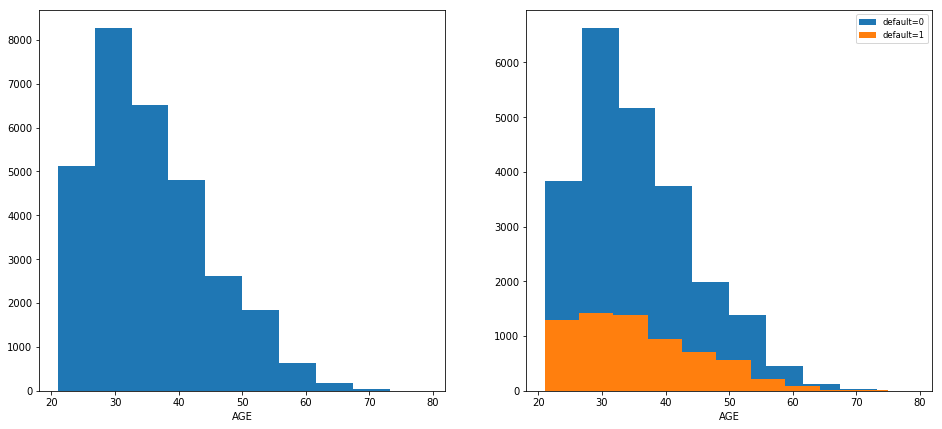

In [164]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(data_scoring.AGE)
plt.xlabel("AGE")
plt.subplot(122)
plt.hist(data_scoring[data_scoring.default==0].AGE,label='default=0')
plt.hist(data_scoring[data_scoring.default==1].AGE,label='default=1')
plt.xlabel("AGE")
plt.legend(loc=0,fontsize='small')

Распределения признаков отличаются от нормального.Также видно, что кредит чаще берут люди от 20 до 40 лет, более старшие реже.Наибольшее количество кредитов берут люди от 30 до 40 лет.

Проверить гипотезу о равенстве медианных значений возрастов людей:
H0: Медианные возраста равны
H1: Медианные возраста отличаются

Построим доверительный интервал на основе бутстрепа

In [165]:
print "Точечная оценка разности медиан ",age_default_0.median()-age_default_1.median()

Точечная оценка разности медиан  0.0


In [166]:
np.random.seed(0)
age_default_0_median_scores=map(np.median,get_bootstrap_samples(np.array(age_default_0),1000))
age_default_1_median_scores=map(np.median,get_bootstrap_samples(np.array(age_default_1),1000))

In [167]:
delta_median_scores=map(lambda x:x[0]-x[1],zip(age_default_0_median_scores,age_default_1_median_scores))

In [168]:
print "95% доверительный интервал разности медиан ",stat_intervals(delta_median_scores,0.05)

95% доверительный интервал разности медиан  [-1.  0.]


Доверительный интервал для разности медиан содержит ноль поэтому мы не можем отвергнуть гипотезу о равенстве медиан.

Проверить гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних:
H0:Средние равны
H1:Средние не равны

Применим критерий Манна-Уитни

In [170]:
stats.mannwhitneyu(age_default_0,age_default_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

Так как p-value больше, чем 0.05 мы не можем отвергнуть гипотезу о равенстве средних.

Вывод: Возраст не значим для данной модели.